In [68]:

import json
import os
from glob import glob


def write_json(dict, label): # wirte the new state into new txt file
    file_name_output=label+'.json'
    print('saving file:',file_name_output)
    with open(file_name_output, 'w') as f:
        json.dump(dict, f)

def write_txt(content, label): # wirte the new state into new txt file
    file_name_output=label+'.txt'
    print('saving file:',file_name_output)
    with open(file_name_output, 'w') as f:
        f.write(content)

def write_csv(df, label):
    df.to_csv(label, sep=',', encoding='utf-8')

def get_labels(path_):
    return os.listdir(path_)

def get_counts(path_):
    # return len(list(glob(path_+'\\*.jpg')))
    # print(path_)
    return len(list(glob(path_)))


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# import glob
import os
import shutil
from collections import Counter
import tensorflow as tf
import keras as keras
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D,\
    Dense, Layer, Reshape, InputLayer, Flatten, Input, MaxPooling2D
from alibi_detect.od import OutlierAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

def img_to_np(path, resize = True):  
    img_array = []
    # fpaths = glob.glob(path, recursive=True)
    fpaths = glob(path, recursive=True)
    for fname in fpaths:
        img = Image.open(fname).convert("RGB")
        if(resize): img = img.resize((64,64))
        img_array.append(np.asarray(img))
    images = np.array(img_array)
    return images
  


In [70]:
def scan_outliers(train, test, path_test):

  encoding_dim = 1024
  dense_dim = [8, 8, 128]

  encoder_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=train[0].shape),
        Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
        Flatten(),
        Dense(encoding_dim,)
    ])

  decoder_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=(encoding_dim,)),
        Dense(np.prod(dense_dim)),
        Reshape(target_shape=dense_dim),
        Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
    ])

  od = OutlierAE( threshold = 0.001,
                  encoder_net=encoder_net,
                  decoder_net=decoder_net)

  adam = tf.keras.optimizers.Adam(lr=1e-4)

  od.fit(train, epochs=20, verbose=True,
        optimizer = adam)

  od.infer_threshold(test, threshold_perc=95)

  preds = od.predict(test, outlier_type='instance',
              return_instance_score=True,
              return_feature_score=True)

  # for i, fpath in enumerate(glob.glob(path_test)):
  for i, fpath in enumerate(glob(path_test)):
      if(preds['data']['is_outlier'][i] == 1):
          source = fpath
          shutil.copy(source, '.\\output\\')
          
  filenames = [os.path.basename(x) for x in glob(path_test, recursive=True)]

  dict1 = {'Filename': filenames,
      'instance_score': preds['data']['instance_score'],
      'is_outlier': preds['data']['is_outlier']}
      
  df = pd.DataFrame(dict1)
  df_outliers = df[df['is_outlier'] == 1]

  return df_outliers

In [71]:
path_='.\\Topic_5_Data\\ISIC84by84\\\\train\\'
# labels = get_labels(path_)

labels = ['DF','VASC','SCC','AK','BKL','BCC','MEL','NV'] 

for label in labels:
    df_outliers = {}
    # path_temp= f'{path_}{label}\\*.*'
    path_temp= path_+label+'\\*.*'
    # print(path_temp)
    
    train = img_to_np(path_temp)
    test = img_to_np(path_temp)
    train = train.astype('float32') / 255.
    test = test.astype('float32') / 255.
    print(f'finding outliers of {label}')
    print(f'processing total {get_counts(path_temp)} images files')
    df_outliers = scan_outliers(train, test, path_temp)
    tar_ = f'.\\output\\alibi_outliers_{label}.csv'
    # write_json(df_outliers, f'.\\output\\alibi_outliers_{label}')
    df_outliers.to_csv(tar_, sep=',', encoding='utf-8')
    # show_line(outliers_path_)





finding outliers of DF
processing total 139 images files


c:\Users\julia\anaconda3\envs\tut2\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


3/3 [=] - 1s 354ms/step - loss_ma: 0.0342
finding outliers of VASC
processing total 153 images files


c:\Users\julia\anaconda3\envs\tut2\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


3/3 [=] - 1s 370ms/step - loss_ma: 0.0286
finding outliers of SCC
processing total 528 images files


c:\Users\julia\anaconda3\envs\tut2\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [=] - 4s 450ms/step - loss_ma: 0.0109
finding outliers of AK
processing total 735 images files


c:\Users\julia\anaconda3\envs\tut2\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


12/12 [=] - 6s 478ms/step - loss_ma: 0.0098
finding outliers of BKL
processing total 2524 images files


c:\Users\julia\anaconda3\envs\tut2\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


40/40 [=] - 19s 465ms/step - loss_ma: 0.0033
finding outliers of BCC
processing total 3223 images files


c:\Users\julia\anaconda3\envs\tut2\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


51/51 [=] - 28s 542ms/step - loss_ma: 0.0024
finding outliers of MEL
processing total 4422 images files


c:\Users\julia\anaconda3\envs\tut2\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


70/70 [=] - 33s 465ms/step - loss_ma: 0.0029
finding outliers of NV
processing total 12775 images files


c:\Users\julia\anaconda3\envs\tut2\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


200/200 [=] - 94s 470ms/step - loss_ma: 0.0011


In [4]:

# path_train = "D:\\img\\capsule\\train\\**\*.*"
# path_test = "D:\\img\\capsule\\test\\**\*.*"
path_train = '.\\Topic_5_Data\\ISIC84by84\\train\\AK\\*.*'
path_test = '.\\Topic_5_Data\\ISIC84by84\\train\\AK\\*.*'

train = img_to_np(path_train)
test = img_to_np(path_test)
train = train.astype('float32') / 255.
test = test.astype('float32') / 255.


encoding_dim = 1024
dense_dim = [8, 8, 128]

encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ])

decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(np.prod(dense_dim)),
      Reshape(target_shape=dense_dim),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

od = OutlierAE( threshold = 0.001,
                encoder_net=encoder_net,
                decoder_net=decoder_net)

adam = tf.keras.optimizers.Adam(lr=1e-4)

od.fit(train, epochs=20, verbose=True,
       optimizer = adam)

od.infer_threshold(test, threshold_perc=95)

preds = od.predict(test, outlier_type='instance',
            return_instance_score=True,
            return_feature_score=True)



12/12 [=] - 6s 485ms/step - loss_ma: 0.0094


In [6]:
for i, fpath in enumerate(glob(path_test)):
# for i, fpath in enumerate(glob.glob(path_test)):
    if(preds['data']['is_outlier'][i] == 1):
        source = fpath
        shutil.copy(source, '.\\output\\')
        
filenames = [os.path.basename(x) for x in glob(path_test, recursive=True)]
# filenames = [os.path.basename(x) for x in glob.glob(path_test, recursive=True)]

dict1 = {'Filename': filenames,
     'instance_score': preds['data']['instance_score'],
     'is_outlier': preds['data']['is_outlier']}
     
df = pd.DataFrame(dict1)
df_outliers = df[df['is_outlier'] == 1]

print(df_outliers)

             Filename  instance_score  is_outlier
10   ISIC_0024948.jpg        0.021646           1
23   ISIC_0026212.jpg        0.026909           1
40   ISIC_0027334.jpg        0.022522           1
49   ISIC_0027668.jpg        0.025716           1
61   ISIC_0028619.jpg        0.022008           1
87   ISIC_0030408.jpg        0.021917           1
136  ISIC_0053749.jpg        0.026168           1
158  ISIC_0054556.jpg        0.023724           1
195  ISIC_0056016.jpg        0.021836           1
200  ISIC_0056128.jpg        0.028449           1
209  ISIC_0056437.jpg        0.025953           1
226  ISIC_0057022.jpg        0.033563           1
252  ISIC_0057586.jpg        0.067568           1
267  ISIC_0058324.jpg        0.049782           1
286  ISIC_0058762.jpg        0.022712           1
324  ISIC_0059827.jpg        0.032709           1
357  ISIC_0060776.jpg        0.029064           1
362  ISIC_0061039.jpg        0.022814           1
374  ISIC_0061385.jpg        0.022610           1


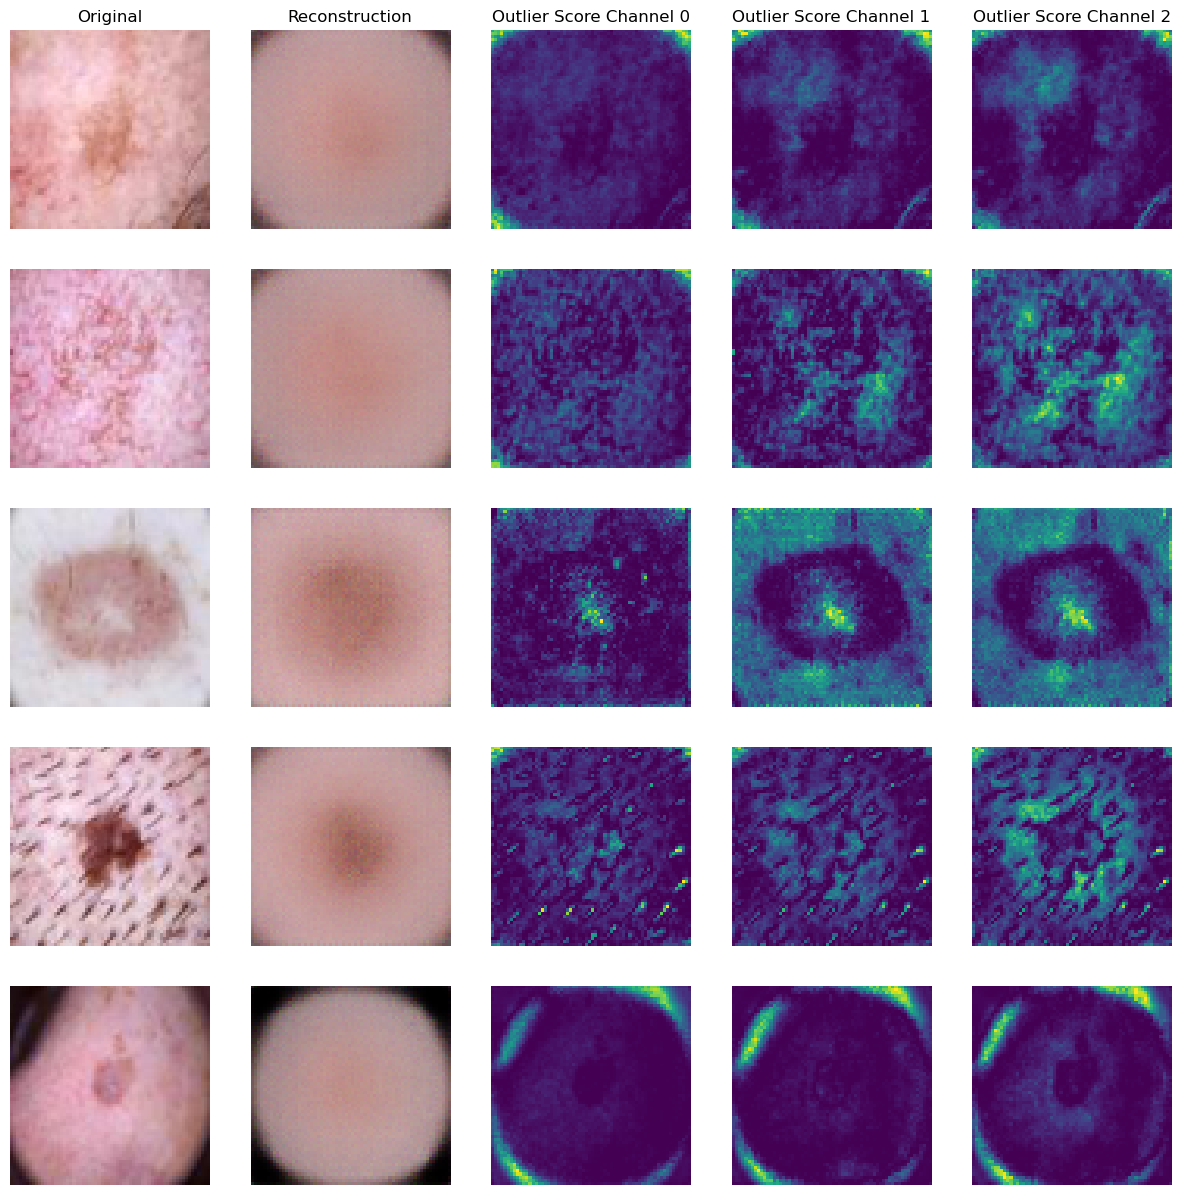

In [8]:

recon = od.ae(test).numpy()

od = OutlierAE( threshold = 0.001,
                encoder_net=encoder_net,
                decoder_net=decoder_net)

plot_feature_outlier_image(preds, test, 
                           X_recon=recon,  
                           max_instances=5,
                           outliers_only=True,
                           figsize=(15,15))